In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

In [121]:
class LinearEnv:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.act_space = [0, 1]  # LEFT = 0, RIGHT = 1
        self.reset()

    def reset(self):
        self._state = np.random.randint(1, 5+1)
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')

        if action == 0: self._state -= 1
        if action == 1: self._state += 1
            
        reward = -1
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True
                
        return self._state, reward, self._done  # obs, rew, done

In [2]:
class WindyGridworld:
    def __init__(self):
        self.act_space = [0, 1, 2, 3]  # LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self.reset()
        
    def reset(self):
        self._x, self._y = 0, 3        # agent initial position
        return (0, 3)
        
    def step(self, action):
        # actions: LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self._x, self._y = self.transition(self._x, self._y, action)
        
        if self._x == 7 and self._y == 3:        # GOAL reached
            return (self._x, self._y), -1, True  # observation, reward, done
        return (self._x, self._y), -1, False     # obs, rew, done 
        
    def transition(self, x, y, action):
        """Perform transition from [x,y] given action"""
        
        if x in [3,4,5,8]:  y += 1    # windy
        if x in [6,7]:      y += 2    # woo, very windy
        
        if action == 0:    x -= 1     # left
        elif action == 1:  y -= 1     # down
        elif action == 2:  x += 1     # right
        elif action == 3:  y += 1     # up
        else: raise ValueError('Action must be in [0,1,2,3]')
            
        x = np.clip(x, 0, 9)   # x range is [0..9]
        y = np.clip(y, 0, 6)   # y range is [0..6]
        return x, y
    
    def get_path(self, Q):
        x, y = 0, 3       # agent starting position
        path = [(x, y)]   # save starting position
        for _ in range(100):  # limit steps in case policy is loopy
            A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])   # pick best action
            x, y = self.transition(x, y, A_star)         # take one step
            path.append((x,y))                            # save to path
            if x == 7 and y == 3:  break                 # if goal: break
        return path

In [3]:
def plot_windy(Q=None, path=None, saveimg=None):
    """Plot windy gridworld.
    
    Will plot optimal action for each cell, according to 'Q'
    and blue line following 'path' parameter
    
    Params:
        Q    - optional, dictionary mappting [(x,y),action] -> float
        path - optional, list [(x1,y1), (x2,y2), ...] of agent steps
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlim(-.5, 9.5)
    ax.set_ylim(-.5, 6.5)
    ax.set_yticks([])
    ax.set_xticks(     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.set_xticklabels([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])

    ax.text(0, 3, 'S', fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax.text(7, 3, 'G', fontsize=18, horizontalalignment='center', verticalalignment='center')
    
    for x in range(10):
        for y in range(7):
            ax.add_patch(patches.Rectangle([x-0.5, y-0.5], 1, 1, fill=False))  # cells

            if Q is not None:
                params = {'head_width':0.2, 'head_length':0.2, 'color':'gray', 'alpha':.2}
                A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])  # pick best action
                if A_star == 3:    ax.arrow(x, y, 0,  .1, **params)  # up
                elif A_star == 1:  ax.arrow(x, y, 0, -.1, **params)  # down
                elif A_star == 0:  ax.arrow(x, y, -.1, 0, **params)  # left
                elif A_star == 2:  ax.arrow(x, y,  .1, 0, **params)  # right

    if path is not None:
        for i in range(len(path)-1):
            x, y = path[i]
            x_, y_ = path[i+1]
            ax.plot([x, x_], [y, y_], color='blue', alpha=1.)

    plt.tight_layout()
    if saveimg is not None:
        plt.savefig(saveimg)
    plt.show()

In [11]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [187]:
def sarsa(env, ep, gamma, alpha, eps):
    """Sarsa (on-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)  # default zero for all, terminal MUST be zero
    N = defaultdict(float)
    
    for _ in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        while True:
            S_, R, done = env.step(A)
            A_ = policy(S_, Q, eps)
            assert not done or Q[S_,A_] == 0.0
            Q[S,A] = Q[S,A] + alpha * (R + gamma * Q[S_,A_] - Q[S,A])
            N[S,A] += 1
            S, A = S_, A_
            if done: break
                
    return Q, N

In [212]:
def generate_episode(env, policy, *params):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done    = env.reset(), None, False
        else:     St, Rt, done    = env.step(At)
        At = policy(St, *params)        
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

In [208]:
def on_policy_MC_control(env, ep, gamma, eps):
    """Monte Carlo ES Control
    Params:
        env - environment
        ep [int] - number of episodes to run
        gamma [float] - discount factor
        eps [float] - epsilon-greedy parameter
    """
    
    def policy(St, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[(St,a)] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)        # default Q value: 0
    Counts = defaultdict(int)
    Returns = defaultdict(float)  # stores SUM
    
    for _ in range(ep):
        traj, T = generate_episode(env, policy, Q, eps)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, At = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            # Do away with first-visit check
            # if not (St, At) in [(traj[i][0], traj[i][3]) for i in range(0, t)]:
            Counts[(St, At)]  += 1
            Returns[(St, At)] += G
            Q[(St, At)] = Returns[(St, At)] / Counts[(St, At)]
                                    
    return Q, Counts

In [188]:
def get_V(state_Q_values, eps):
    assert isinstance(state_Q_values, list)
    assert all(isinstance(f, float) for f in state_Q_values)
    index_max = argmax_rand(state_Q_values)
    max_val = state_Q_values[index_max]
    avg_val = sum([q for q in state_Q_values]) / len(state_Q_values)
    return (1-eps)*max_val + eps*avg_val

assert get_V([0.0, 1.0, 0.0, 0.0], eps=0.1) == 0.925
assert get_V([-1.0, -1.0, 2.0, 0.0], eps=0.1) == 1.8
assert get_V([1.0, 2.0, 3.0, 4.0], eps=0.1) == 3.85

In [189]:
env = LinearEnv()
Q, N = sarsa(env, 10000, gamma=1., alpha=.5, eps=.1)

In [213]:
env = LinearEnv()
Q, N = on_policy_MC_control(env, 10000, gamma=1., eps=.1)

In [214]:
V = np.zeros(7)
N_ = np.zeros(7)
for x in range(7):
    q_0, q_1 = Q[(x,0)], Q[(x,1)]
    v = get_V([q_0, q_1], eps=0.1)
    V[x] = v
    N_[x] = N[(x,0)] + N[(x,1)]
    print(x, v)

0 0.0
1 -1.1128630705394191
2 -2.259499824841384
3 -3.221662909349787
4 -2.2187194092827007
5 -1.1123839009287926
6 0.0


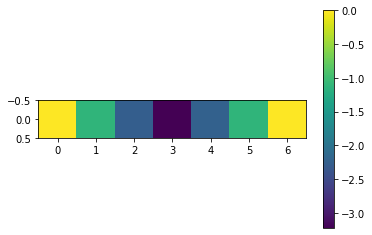

In [215]:
plt.imshow(np.expand_dims(V.T, axis=0))
plt.colorbar()

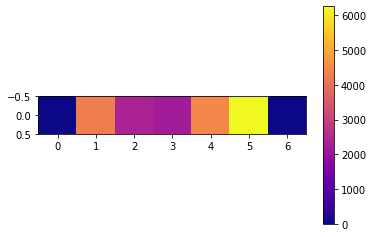

In [216]:
plt.imshow(np.expand_dims(N_.T, axis=0), cmap='plasma')
plt.colorbar()

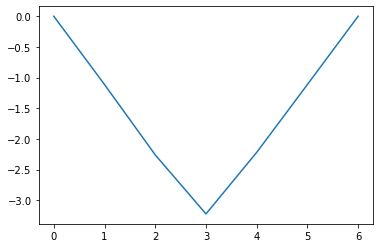

In [217]:
plt.plot(V)

In [242]:
env = WindyGridworld()
Q, N = sarsa(env, 1000, gamma=1., alpha=.5, eps=.3)

In [247]:
env = WindyGridworld()
Q, N = on_policy_MC_control(env, 10, gamma=1., eps=.3)

KeyboardInterrupt: 

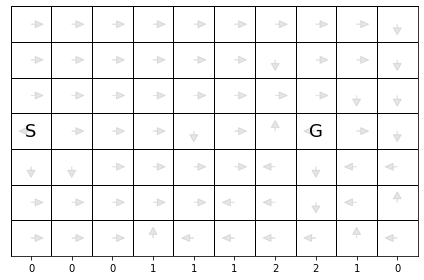

In [243]:
optimal_path = env.get_path(Q)
plot_windy(Q, optimal_path)

In [244]:
V_ = np.zeros((6, 9))
N_ = np.zeros((6, 9))
for x in range(9):
    for y in range(6):
        q_0, q_1, q_2, q_3 = Q[((x,y),0)], Q[((x,y),1)], Q[((x,y),2)], Q[((x,y),3)]
        v = get_V([q_0, q_1, q_2, q_3], eps=.1)
        V_[y, x] = v
        N_[y, x] = N[((x,y),0)] + N[((x,y),1)] + N[((x,y),2)] + N[((x,y),3)]

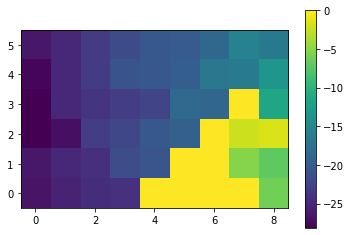

In [245]:
plt.imshow(V_, origin='lower')
plt.colorbar()

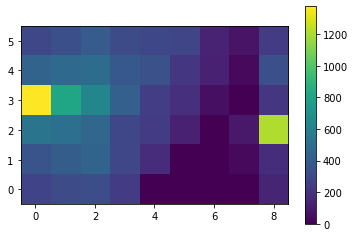

In [246]:
plt.imshow(N_, origin='lower')
plt.colorbar()